In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
df = pd.read_csv("international-airline-passengers.csv")

In [12]:
df.head()

,Month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


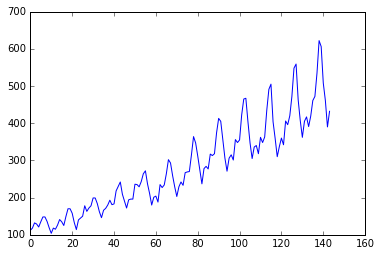

In [13]:
plt.plot(df.passengers)

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
# 標準化
sc = MinMaxScaler()
dataset = sc.fit_transform(df.passengers.values)

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [16]:
df["passengers"] = dataset
df["p_1"] = df.passengers.shift(1)
df["p_2"] = df.passengers.shift(2)
df["p_3"] = df.passengers.shift(3)
df = df.dropna()

In [17]:
df.head()

,Month,passengers,p_1,p_2,p_3
3,1949-04,0.048263,0.054054,0.027027,0.015444
4,1949-05,0.032819,0.048263,0.054054,0.027027
5,1949-06,0.059846,0.032819,0.048263,0.054054
6,1949-07,0.084942,0.059846,0.032819,0.048263
7,1949-08,0.084942,0.084942,0.059846,0.032819


In [18]:
#sc.inverse_transform(dataset)

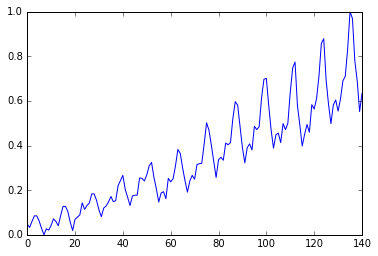

In [19]:
plt.plot(df["passengers"].values)

In [20]:
def create_dataset(dataset, steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(dataset)-steps_of_history, steps_in_future):
        X.append(dataset[i:i+steps_of_history])
        Y.append(dataset[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, steps_of_history, 1])
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 1
steps_in_future = 1

X, Y = create_dataset(dataset, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.33)

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [310]:
#N=0.33
#Len = int(N*len(df))
#trainX = df.passengers[:-Len].values.astype("float32")
#trainY = df.p_1[:-Len].values.astype("float32")
#testX = df.passengers[-Len:].values.astype("float32")
#testY = df.p_1[-Len:].values.astype("float32")

In [21]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [50]:
class LSTM(nn.Module):

    def __init__(self, hidden_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(1, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(1, 1, self.hidden_dim)),
                Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, inputs):
        lstm_out, self.hidden = self.lstm(inputs, self.hidden)
        predict = F.sigmoid(self.linear(lstm_out.view(1, -1)))
        return predict

In [31]:
model = LSTM(30)

In [32]:
#最適化手法
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
#loss関数の定義
criterion = nn.MSELoss()

In [33]:
loss_history = []
for loop in range(100):
    running_loss = 0.0
    for x, y in zip(trainX, trainY):
        inputs = Variable(torch.Tensor(x.reshape(1,1)).view(1,1,-1))
        label = Variable(torch.Tensor(y.reshape(1,1)))
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
        
        output = model(inputs)

        loss = criterion(output, label)
        running_loss += loss.data[0]

        #backpropagation
        loss.backward()
        optimizer.step()

    if loop % 5 == 0: print('[epoch %d]  loss: %.3f' % (loop + 1, running_loss / len(trainX)))
    loss_history.append(running_loss / len(trainX))

[epoch 1]  loss: 0.055
[epoch 6]  loss: 0.019
[epoch 11]  loss: 0.015
[epoch 16]  loss: 0.009
[epoch 21]  loss: 0.004
[epoch 26]  loss: 0.003
[epoch 31]  loss: 0.003
[epoch 36]  loss: 0.003
[epoch 41]  loss: 0.003
[epoch 46]  loss: 0.003
[epoch 51]  loss: 0.003
[epoch 56]  loss: 0.003
[epoch 61]  loss: 0.003
[epoch 66]  loss: 0.002
[epoch 71]  loss: 0.002
[epoch 76]  loss: 0.002
[epoch 81]  loss: 0.002
[epoch 86]  loss: 0.002
[epoch 91]  loss: 0.002
[epoch 96]  loss: 0.002


In [34]:
train_predict = []
for x in trainX:
    inputs = Variable(torch.Tensor(x.reshape(1,1)).view(1,1,-1))
    model.hidden = model.init_hidden()
    output = model(inputs)
    train_predict.append(output[0].data.numpy())

In [35]:
test_predict = []
for x in X:
    inputs = Variable(torch.Tensor(x.reshape(1,1)).view(1,1,-1))
    model.hidden = model.init_hidden()
    output = model(inputs)
    test_predict.append(output[0].data.numpy())

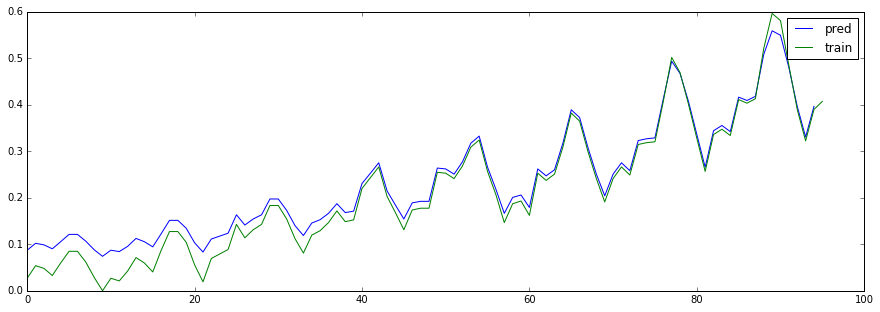

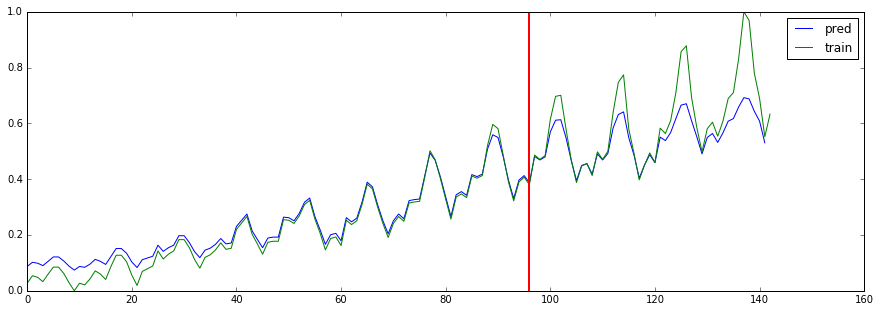

In [36]:
plt.figure(figsize=(15,5))
plt.plot(train_predict[1:],label="pred")
plt.plot(trainY,label="train")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_predict[1:],label="pred")
plt.plot(Y,label="train")
plt.plot([len(trainY),len(trainY)],[0,1],  lw=2)
plt.legend()
plt.show()

In [43]:
class GRU(nn.Module):
    def __init__(self,  hidden_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(1, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
        self.hidden = self.init_hidden()
        

    def forward(self, inputs):
        _, hn = self.gru(inputs, self.hidden)
        ## from (1, N, hidden) to (N, hidden)
        rearranged = hn.view(hn.size()[1], hn.size(2))
        out1 = F.sigmoid(self.linear(rearranged))
        return out1
    
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return Variable(torch.zeros(1, 1, self.hidden_dim))

In [72]:
model = GRU(30)

In [73]:
optimizer = optim.RMSprop(model.parameters(), lr = 0.001)
criterion = nn.L1Loss()

In [74]:
loss_history = []
for loop in range(100):
    running_loss = 0.0
    for x, y in zip(trainX, trainY):
        inputs = Variable(torch.Tensor(x.reshape(1,1)).view(1,1,-1))
        label = Variable(torch.Tensor(y.reshape(1,1)))
        optimizer.zero_grad()
        model.hidden = model.init_hidden()
        
        output = model(inputs)

        loss = criterion(output, label)
        running_loss += loss.data[0]

        #backpropagation
        loss.backward()
        optimizer.step()

    if loop % 5 == 0: print('[epoch %d]  loss: %.3f' % (loop + 1, running_loss / len(trainX)))
    loss_history.append(running_loss / len(trainX))

[epoch 1]  loss: 0.183
[epoch 6]  loss: 0.110
[epoch 11]  loss: 0.080
[epoch 16]  loss: 0.054
[epoch 21]  loss: 0.045
[epoch 26]  loss: 0.044
[epoch 31]  loss: 0.044
[epoch 36]  loss: 0.044
[epoch 41]  loss: 0.044
[epoch 46]  loss: 0.043
[epoch 51]  loss: 0.043
[epoch 56]  loss: 0.043
[epoch 61]  loss: 0.043
[epoch 66]  loss: 0.043
[epoch 71]  loss: 0.042
[epoch 76]  loss: 0.043
[epoch 81]  loss: 0.042
[epoch 86]  loss: 0.042
[epoch 91]  loss: 0.042
[epoch 96]  loss: 0.042


In [75]:
train_predict = []
for x in trainX:
    inputs = Variable(torch.Tensor(x.reshape(1,1)).view(1,1,-1))
    model.hidden = model.init_hidden()
    output = model(inputs)
    train_predict.append(output[0].data.numpy())

In [76]:
test_predict = []
for x in X:
    inputs = Variable(torch.Tensor(x.reshape(1,1)).view(1,1,-1))
    model.hidden = model.init_hidden()
    output = model(inputs)
    test_predict.append(output[0].data.numpy())

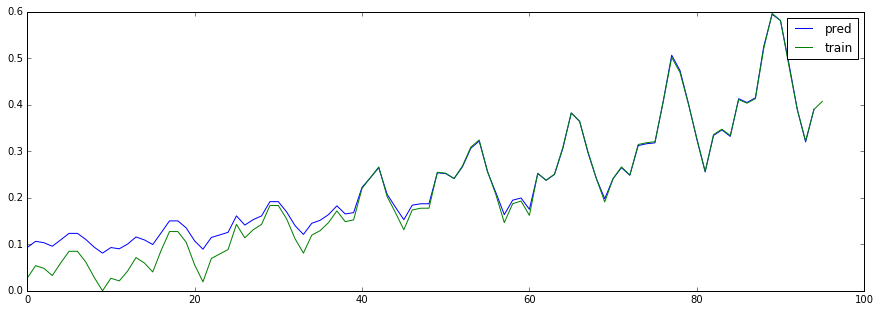

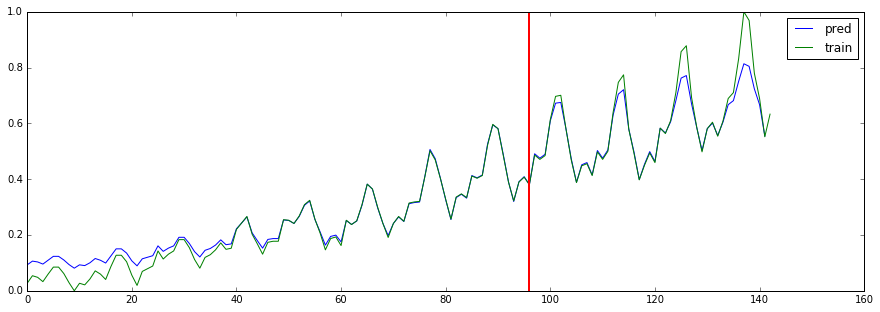

/Users/sho/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide


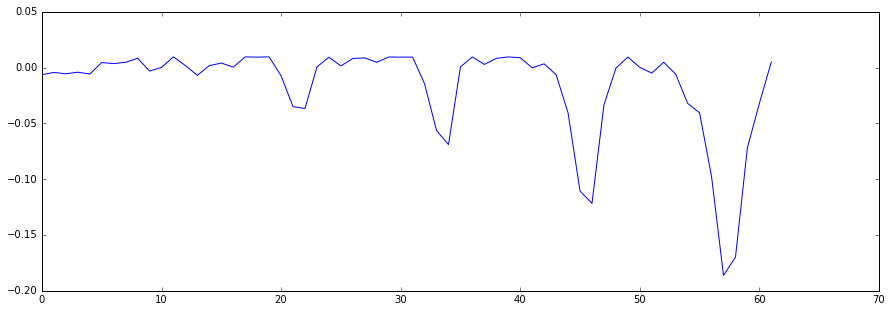

In [79]:
plt.figure(figsize=(15,5))
plt.plot(train_predict[1:],label="pred")
plt.plot(trainY,label="train")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_predict[1:],label="pred")
plt.plot(Y,label="train")
plt.plot([len(trainY),len(trainY)],[0,1],  lw=2)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(((np.array(test_predict[1:])-np.array(Y[:-1]))/np.array(Y[:-1]))[80:])
plt.show()

In [348]:
## RandomForestRegression